In [2]:
## Requirements:
!pip install librosa numpy scikit-learn matplotlib seaborn

In [3]:
import os
import librosa
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
DATASET_PATH = "dataset"

In [5]:
emotion_labels = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

In [6]:
def extract_features(file_path, max_pad_len=100):
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return np.mean(mfccs, axis=1)  # Mean of MFCCs to reduce dimensions

In [8]:
for file in os.listdir(actor_path):
    if not file.endswith(".wav"):  
        print(f"Skipping non-audio file: {file}")
        continue  

    file_path = os.path.join(actor_path, file)
    parts = file.split("-")
    
    if len(parts) < 3:  
        print(f"Skipping improperly named file: {file}")
        continue  

    emotion_code = parts[2]  
    if emotion_code in emotion_labels:
        features = extract_features(file_path)
        X.append(features)
        y.append(emotion_labels[emotion_code])

Skipping non-audio file: Actor_01
Skipping non-audio file: Actor_02
Skipping non-audio file: Actor_03
Skipping non-audio file: Actor_04
Skipping non-audio file: Actor_05
Skipping non-audio file: Actor_06
Skipping non-audio file: Actor_07
Skipping non-audio file: Actor_08
Skipping non-audio file: Actor_09
Skipping non-audio file: Actor_10
Skipping non-audio file: Actor_11
Skipping non-audio file: Actor_12
Skipping non-audio file: Actor_13
Skipping non-audio file: Actor_14
Skipping non-audio file: Actor_15
Skipping non-audio file: Actor_16
Skipping non-audio file: Actor_17
Skipping non-audio file: Actor_18
Skipping non-audio file: Actor_19
Skipping non-audio file: Actor_20
Skipping non-audio file: Actor_21
Skipping non-audio file: Actor_22
Skipping non-audio file: Actor_23
Skipping non-audio file: Actor_24


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
gmm_models = {}

for emotion in np.unique(y_train):
    gmm = GaussianMixture(n_components=4, max_iter=200, covariance_type='diag', random_state=42)

    # Fix: Convert X_train subset into a 2D array before fitting
    X_emotion = np.array([x for x, y in zip(X_train, y_train) if y == emotion])
    X_emotion = X_emotion.reshape(len(X_emotion), -1)  # Ensure 2D shape

    gmm.fit(X_emotion)
    gmm_models[emotion] = gmm

E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

In [12]:
y_pred = []

for x in X_test:
    scores = {emotion: gmm_models[emotion].score_samples([x]).sum() for emotion in gmm_models}
    y_pred.append(max(scores, key=scores.get))

y_pred = np.array(y_pred)

Accuracy: 0.2673611111111111

Classification Report:
               precision    recall  f1-score   support

       angry       0.34      0.36      0.35        42
        calm       0.45      0.34      0.39        44
     disgust       0.19      0.38      0.25        32
     fearful       0.32      0.31      0.32        32
       happy       0.16      0.15      0.15        34
     neutral       0.20      0.25      0.22        20
         sad       0.19      0.15      0.17        39
   surprised       0.32      0.20      0.25        45

    accuracy                           0.27       288
   macro avg       0.27      0.27      0.26       288
weighted avg       0.28      0.27      0.27       288



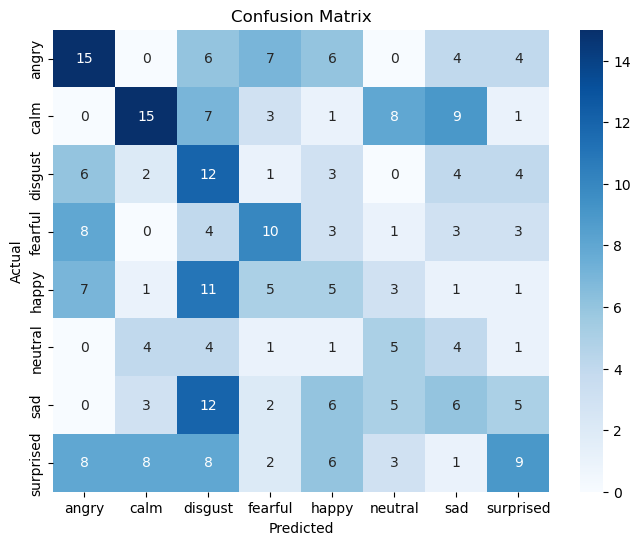

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
with open("gmm_model.pkl", "wb") as f:
    pickle.dump(gmm_models, f)

In [16]:
with open("gmm_model.pkl", "rb") as f:
    gmm_models = pickle.load(f)

def predict_emotion(file_path):
    features = extract_features(file_path)
    scores = {emotion: gmm_models[emotion].score_samples([features]).sum() for emotion in gmm_models}
    return max(scores, key=scores.get)

test_audio = "dataset/Actor_01/03-01-02-02-01-02-01.wav"  # Change as needed
predicted_emotion = predict_emotion(test_audio)
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: calm


In [1]:
import pickle
import numpy as np
import librosa
import librosa.display 
import IPython.display as ipd
import tkinter as tk
from tkinter import filedialog

# Function to extract MFCC features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Load trained GMM models
with open("gmm_model.pkl", "rb") as f:
    gmm_models = pickle.load(f)

# Function to let user select a file
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
    return file_path

# Let user select the .wav file
file_path = select_file()
if not file_path:
    print("⚠️ No file selected. Please try again.")
else:
    # Predict function
    def predict_emotion(file_path):
        features = extract_features(file_path)
        scores = {emotion: gmm_models[emotion].score_samples([features]).sum() for emotion in gmm_models}
        return max(scores, key=scores.get)

    # Run prediction
    predicted_emotion = predict_emotion(file_path)
    print(f"🎭 Predicted Emotion: {predicted_emotion}")

    # Play the selected file
    ipd.Audio(file_path)

E:\Anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
E:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
E:\Anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


🎭 Predicted Emotion: disgust
